In [89]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from kneed import KneeLocator
import os
import sys
import pickle

sys.path.append("../scripts")
from utils import Utils
from clean_data import DataCleaner

cleaner = DataCleaner()
utility = Utils()

In [2]:
cleaned_df=utility.load_data("../data/cleaned_data.csv")
# since our csv file doesn't have a meta data of columns dtype, we manually convert ['bearer_id', 'imsi', 'msisdn/number', 'imei','handset_type'] to string once again
cleaned_df=cleaner.convert_to_string(cleaned_df)

In [3]:
cleaned_df.shape

(150001, 55)

In [4]:
cleaned_df.isnull().sum().sum()

0

In [5]:
#Group data by MSISDN
msisdn_group = cleaned_df.groupby("msisdn/number")

session Frequency

In [26]:
session_freq=msisdn_group.agg({"bearer_id":"count"})

session_freq.rename(columns={"bearer_id":"session_frequency"},inplace=True)

session_freq.sort_values(by=["session_frequency"],ascending=False,inplace=True)
session_freq.drop(['nan'],axis=0,inplace=True)
session_freq.head(10)

,session_frequency
msisdn/number,
33626320676.0,18
33625779332.0,17
33614892860.0,17
33659725664.0,16
33760536639.0,15
33675877202.0,15
33667163239.0,13
33604515716.0,12
33786323068.0,12


session duration

In [28]:
session_dur=msisdn_group.agg({"dur._(ms)":"sum"})
session_dur.rename(columns={"dur._(ms)":"duration_ms"},inplace=True)
session_dur.sort_values(by=['duration_ms'],ascending=False,inplace=True)
session_dur.drop(['nan'],axis=0,inplace=True)
session_dur.head(10)

,duration_ms
msisdn/number,
33625779332.0,18553754.0
33614892860.0,9966898.0
33760536639.0,9279434.0
33626320676.0,8791927.0
33667163239.0,8744914.0
33662840755.0,6614270.0
33664693736.0,6288730.0
33603127838.0,6287761.0
33667456716.0,5649882.0


In [31]:
cleaned_df["grand_total"]=cleaned_df['total_ul_(bytes)']+cleaned_df['total_dl_(bytes)']
total_data=msisdn_group.agg({'total_ul_(bytes)':'sum','total_dl_(bytes)':'sum'})
total_data['grand_total_(bytes)']=total_data['total_ul_(bytes)']+total_data['total_dl_(bytes)']
total_data.sort_values(by=['grand_total_(bytes)'],ascending=False,inplace=True)
total_data.drop(['nan'],axis=0,inplace=True)
total_data.head(10)

,total_ul_(bytes),total_dl_(bytes),grand_total_(bytes)
msisdn/number,,,
33614892860.0,689483001.0,8.156743e+09,8.846226e+09
33760536639.0,703478581.0,7.811295e+09,8.514774e+09
33625779332.0,729577380.0,7.770043e+09,8.499621e+09
33626320676.0,669650721.0,7.301517e+09,7.971167e+09
33675877202.0,581568792.0,7.309542e+09,7.891111e+09
33659725664.0,624260321.0,7.081602e+09,7.705863e+09
33666464084.0,405060976.0,6.903440e+09,7.308501e+09
33760413819.0,521518890.0,6.610852e+09,7.132371e+09
33664712899.0,471244453.0,6.400774e+09,6.872018e+09


In [34]:

# Aggregate User Engagement Metric
user_engagement = msisdn_group.agg({'grand_total': 'sum', 'dur._(ms)': 'sum','bearer_id': 'count'})
user_engagement = user_engagement.rename(columns={'grand_total': 'session_traffic(bytes)', 'dur._(ms)': 'session_duration(ms)', 'bearer_id': 'session_freq'})
user_engagement.drop(['nan'],axis=0,inplace=True)
user_engagement


,session_traffic(bytes),session_duration(ms),session_freq
msisdn/number,,,
3197020876596.0,2.321240e+08,877385.0,1
33601001722.0,8.786906e+08,116720.0,1
33601001754.0,1.568596e+08,181230.0,1
33601002511.0,5.959665e+08,134969.0,1
33601007832.0,4.223207e+08,49878.0,1
...,...,...,...
33789967113.0,2.081231e+08,160461.0,1
33789980299.0,1.094693e+09,210389.0,2
33789996170.0,7.146416e+08,8810.0,1


## Top 10 customers per engagement metric

In [48]:


# print("Top 10 Customers per engagement by Session Traffic")
# print(user_engagement.sort_values(by=['session_traffic(bytes)'],ascending=False).head(10))
# print()

# print("Top 10 Customers per engagement by Session Duration")
# print(user_engagement.sort_values(by=['session_duration(ms)'],ascending=False).head(10))
# print()

# print("Top 10 Customers per engagement by Session Frequency")
# print(user_engagement.sort_values(by=['session_freq'],ascending=False).head(10))
# print()

### by session_traffic

In [37]:
user_engagement.sort_values(by=['session_traffic(bytes)'],ascending=False).head(10)

,session_traffic(bytes),session_duration(ms),session_freq
msisdn/number,,,
33614892860.0,8.846226e+09,9966898.0,17
33760536639.0,8.514774e+09,9279434.0,15
33625779332.0,8.499621e+09,18553754.0,17
33626320676.0,7.971167e+09,8791927.0,18
33675877202.0,7.891111e+09,4865947.0,15
33659725664.0,7.705863e+09,4035428.0,16
33666464084.0,7.308501e+09,4536757.0,11
33760413819.0,7.132371e+09,5321667.0,12
33664712899.0,6.872018e+09,2927785.0,11


### by session_duration

In [38]:
user_engagement.sort_values(by=['session_duration(ms)'],ascending=False).head(10)

,session_traffic(bytes),session_duration(ms),session_freq
msisdn/number,,,
33625779332.0,8.499621e+09,18553754.0,17
33614892860.0,8.846226e+09,9966898.0,17
33760536639.0,8.514774e+09,9279434.0,15
33626320676.0,7.971167e+09,8791927.0,18
33667163239.0,5.618394e+09,8744914.0,13
33662840755.0,4.000098e+09,6614270.0,9
33664693736.0,5.682007e+09,6288730.0,9
33603127838.0,4.976195e+09,6287761.0,12
33667456716.0,2.600522e+09,5649882.0,6


### by session_freq

In [39]:
user_engagement.sort_values(by=['session_freq'],ascending=False).head(10)

,session_traffic(bytes),session_duration(ms),session_freq
msisdn/number,,,
33626320676.0,7.971167e+09,8791927.0,18
33614892860.0,8.846226e+09,9966898.0,17
33625779332.0,8.499621e+09,18553754.0,17
33659725664.0,7.705863e+09,4035428.0,16
33760536639.0,8.514774e+09,9279434.0,15
33675877202.0,7.891111e+09,4865947.0,15
33667163239.0,5.618394e+09,8744914.0,13
33627080969.0,5.754731e+09,4703516.0,12
33604515716.0,5.487855e+09,5207990.0,12


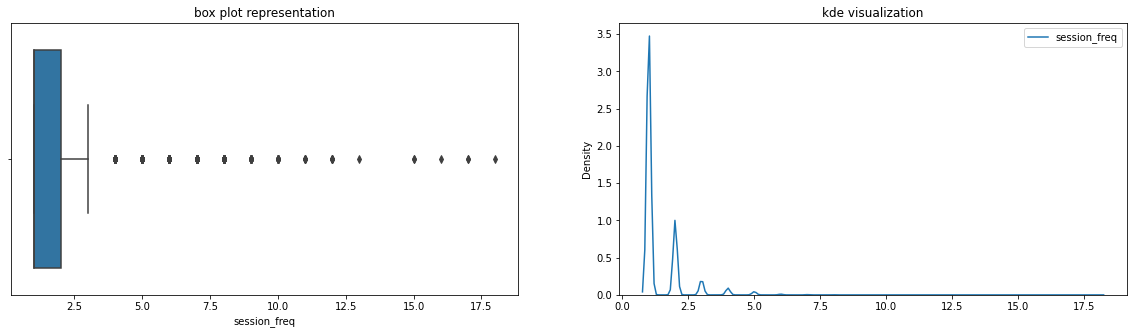

In [70]:
plt.figure(figsize=(20,5))

plt.subplot(1,2,1,title="box plot representation")
sns.boxplot(data=user_engagement[['session_freq']],x="session_freq")

plt.subplot(1,2,2,title="kde visualization")
sns.kdeplot(data=user_engagement[['session_freq']])

plt.show()

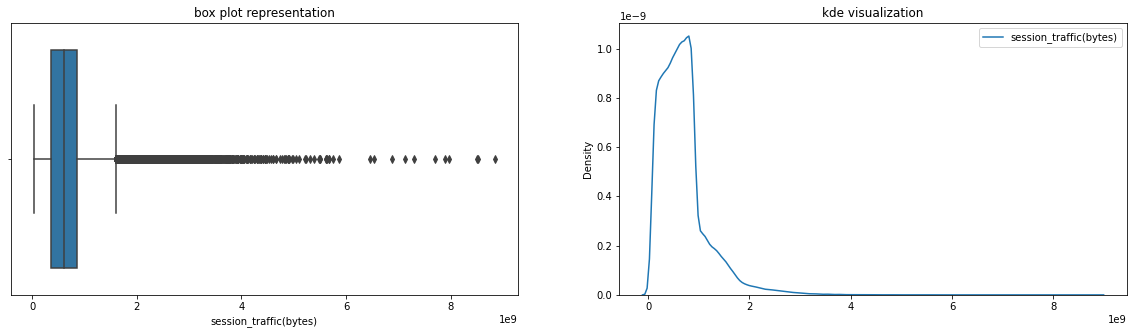

In [71]:
plt.figure(figsize=(20,5))

plt.subplot(1,2,1,title="box plot representation")
sns.boxplot(data=user_engagement[['session_traffic(bytes)']],x="session_traffic(bytes)")

plt.subplot(1,2,2,title="kde visualization")
sns.kdeplot(data=user_engagement[['session_traffic(bytes)']])

plt.show()

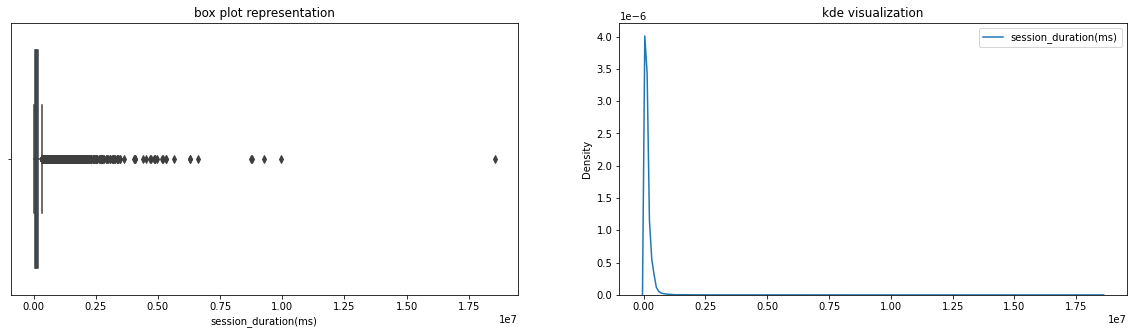

In [72]:
plt.figure(figsize=(20,5))

plt.subplot(1,2,1,title="box plot representation")
sns.boxplot(data=user_engagement[['session_duration(ms)']],x="session_duration(ms)")

plt.subplot(1,2,2,title="kde visualization")
sns.kdeplot(data=user_engagement[['session_duration(ms)']])

plt.show()

handle outliers

In [76]:
cleaned_engagement_metric = cleaner.handle_outliers(user_engagement, 'session_freq')
cleaned_engagement_metric = cleaner.handle_outliers(cleaned_engagement_metric, 'session_duration(ms)')
cleaned_engagement_metric = cleaner.handle_outliers(cleaned_engagement_metric, 'session_traffic(bytes)')
cleaned_engagement_metric2 = cleaned_engagement_metric.copy()
cleaned_engagement_metric

,session_traffic(bytes),session_duration(ms),session_freq
msisdn/number,,,
3197020876596.0,2.321240e+08,325035.5,1.0
33601001722.0,8.786906e+08,116720.0,1.0
33601001754.0,1.568596e+08,181230.0,1.0
33601002511.0,5.959665e+08,134969.0,1.0
33601007832.0,4.223207e+08,49878.0,1.0
...,...,...,...
33789967113.0,2.081231e+08,160461.0,1.0
33789980299.0,1.094693e+09,210389.0,2.0
33789996170.0,7.146416e+08,8810.0,1.0


Data Distribution after handling outliers

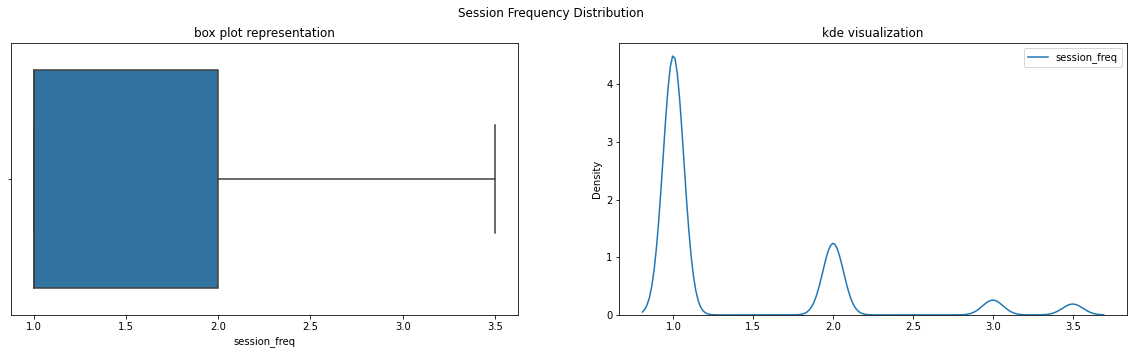

In [82]:
plt.figure(figsize=(20,5))

plt.subplot(1,2,1,title="box plot representation")
sns.boxplot(data=cleaned_engagement_metric[['session_freq']],x="session_freq")

plt.subplot(1,2,2,title="kde visualization")
sns.kdeplot(data=cleaned_engagement_metric[['session_freq']])

plt.suptitle("Session Frequency Distribution")
plt.show()

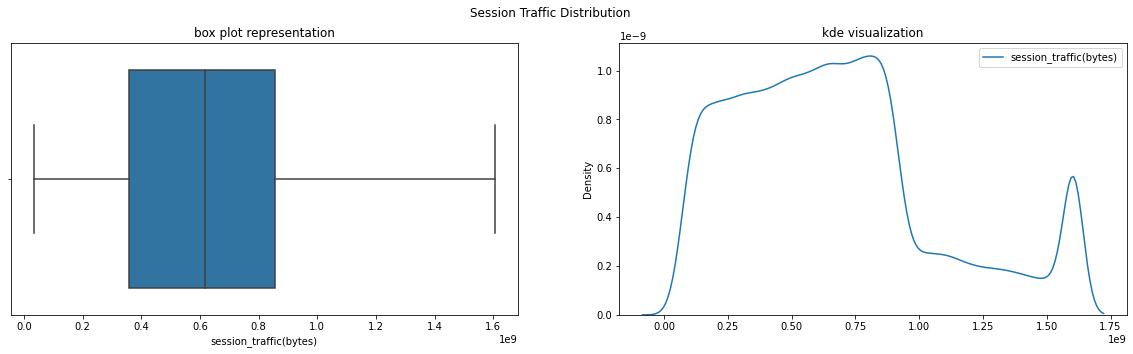

In [83]:
plt.figure(figsize=(20,5))

plt.subplot(1,2,1,title="box plot representation")
sns.boxplot(data=cleaned_engagement_metric[['session_traffic(bytes)']],x="session_traffic(bytes)")

plt.subplot(1,2,2,title="kde visualization")
sns.kdeplot(data=cleaned_engagement_metric[['session_traffic(bytes)']])

plt.suptitle("Session Traffic Distribution")
plt.show()

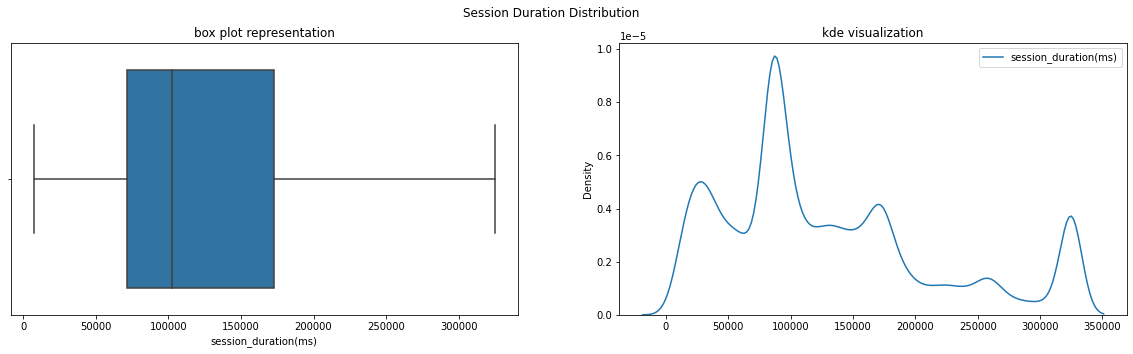

In [84]:
plt.figure(figsize=(20,5))

plt.subplot(1,2,1,title="box plot representation")
sns.boxplot(data=cleaned_engagement_metric[['session_duration(ms)']],x="session_duration(ms)")

plt.subplot(1,2,2,title="kde visualization")
sns.kdeplot(data=cleaned_engagement_metric[['session_duration(ms)']])

plt.suptitle("Session Duration Distribution")
plt.show()

as we can see we managed to significantly reduce the skewness of the data

Customer clustering (K-means)
- Normalize each engagement metric and run a k-means (k=3) to classify customers in three groups of engagement. 


In [85]:
# normalize the data
normalized_engagement_metric = cleaner.normalizer(cleaned_engagement_metric)
normalized_engagement_metric

,session_traffic(bytes),session_duration(ms),session_freq
0,0.999999,0.001400,4.308039e-09
1,1.000000,0.000133,1.138057e-09
2,0.999999,0.001155,6.375122e-09
3,1.000000,0.000226,1.677947e-09
4,1.000000,0.000118,2.367869e-09
...,...,...,...
106851,1.000000,0.000771,4.804848e-09
106852,1.000000,0.000192,1.826996e-09
106853,1.000000,0.000012,1.399303e-09
106854,1.000000,0.000294,2.082000e-09


In [87]:
kmeans= KMeans(
    init="k-means++",
    n_clusters= 3,
    n_init= 10,
    max_iter= 300,
    random_state=20  
)

In [88]:
model = kmeans.fit(normalized_engagement_metric)
centroids = kmeans.cluster_centers_

In [90]:
with open("../models/user_engamenet_metric_clustering_model.pkl", "wb") as f:
    pickle.dump(model, f)